### importing libraries

In [1]:
#librarises
import cv2
import numpy as np
from typing import Tuple
from cpselect.cpselect import cpselect
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.io as io
from scipy.linalg import rq
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d

### function for showing image

In [2]:
#function to display image
def show_image(image, is_gray = False, title = None, figsize=None):
    if figsize:
        plt.figure(figsize=figsize)
        
    if is_gray:
        plt.imshow(image, cmap="gray")
    else:
        plt.imshow(image[..., ::-1])
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()


### Selecting corresponding points bewtween image 1 and image 2

In [3]:
im1 = cv2.imread("taj1.jpg")
im2 = cv2.imread("taj2.jpg")

#Converting images to gray-scale
grayim1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
grayim2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

sift = cv2.ORB_create(nfeatures=2000)

#Finding keypoints and descriptors for Mountain images
pq1, desc1 = sift.detectAndCompute(grayim1, None)
pq2, desc2 = sift.detectAndCompute(grayim2, None)

brutef = cv2.BFMatcher()

#Matching the keypoints with k-nearest neighbor (with k=2)
matches = brutef.knnMatch(desc1, desc2, k=2)

goodMatch = []
#Performing ratio test to find good matches
for m, n in matches:
    if m.distance < 0.75*n.distance:
        goodMatch.append(m)
    #print(m)
        
#Getting source and destination points
pq1 = np.float32([ pq1[m.queryIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
pq2 = np.float32([ pq2[m.trainIdx].pt for m in goodMatch]).reshape(-1, 1, 2)
p1 = []
p2 = []

for i in range(0, len(pq1)):
    p1.append(pq1[i][0][0])
    p1.append(pq1[i][0][1])
    p2.append(pq2[i][0][0])
    p2.append(pq2[i][0][1])
    
p1 = np.array(p1)
p2 = np.array(p2)

p1 = p1.reshape(-1, 2)
p2 = p2.reshape(-1, 2)

np.savez("taj_points.npz", p1 = p1, p2 = p2, im1=im1, im2=im2)


### Q2.2 ComputeH

In [4]:
def computeH(p1:np.array, p2:np.array) -> np.array:
    
    '''
    A = []
    for i in range(0, len(p1)):
        x, y = p1[i, 0], p1[i, 1]
        u, v = p2[i, 0], p2[i, 1]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
    A = np.asarray(A)
    U, S, V = np.linalg.svd(A)
    L = V[-1,:] / V[-1,-1]
    h = L.reshape(3, 3)
    '''
    h, _ = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0)
    return h


if __name__ == "__main__":
    points = np.load("taj_points.npz")
    p1 = points["p1"]
    p2 = points["p2"]
    H = computeH(p1, p2)
   
    print("Homography matrix: \n", H)

Homography matrix: 
 [[ 1.88746269e+00 -1.78053252e-01 -1.18305169e+03]
 [ 4.51017879e-01  1.59988044e+00 -4.99154089e+02]
 [ 5.59532027e-04 -1.70997475e-05  1.00000000e+00]]


### Q2.3 Compute H_Norm

In [5]:
def normalize(x:np.array, nd:int=2) -> Tuple[np.array, np.array]:
    '''
    Normalization of coordinates
    Args:
    x: the data to be normalized
    nd: number of dimensions
    '''
    m, s = np.mean(x, 0), np.std(x)
    if nd == 2:
        Tr = np.array([[s, 0, m[0]], [0, s, m[1]], [0, 0, 1]])
    else:
        Tr = np.array([[s, 0, 0, m[0]], [0, s, 0, m[1]], [0, 0, s, m[2]], [0,0, 0, 1]])
        
    Tr = np.linalg.inv(Tr)
    x = np.dot(Tr, np.concatenate([x.T, np.ones((1,x.shape[0]))]))
    x = x[0:nd, :].T
    
    return Tr, x

def computeH_norm(p1:np.array, p2:np.array) -> np.array:
    T1, p1 = normalize(p1)
    T2, p2 = normalize(p2)
    H_ = computeH(p1, p2)
    H = np.dot(np.dot(np.linalg.pinv(T2), H_), T1)
    H = H / H[-1, -1]
    return H
if __name__ == "__main__":
    points = np.load("taj_points.npz")
    p1     = points["p1"]
    p2     = points["p2"]
       
    H_norm = computeH_norm(p1, p2)
    print("Normalised Homoraphix matrix is: \n", H_norm)
    #M, out_size     = computeM(im1, im2, H2to1)


Normalised Homoraphix matrix is: 
 [[-1.19151994e+00 -3.39748890e-01  1.00070252e+03]
 [-1.42422368e+00 -5.59772232e-01  1.29326707e+03]
 [-1.83322725e-03  8.42478692e-05  1.00000000e+00]]


### Q2.4 Image warping

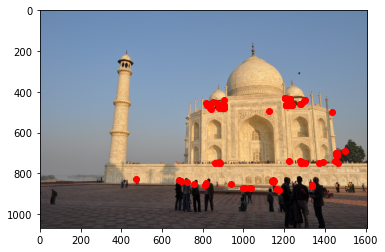

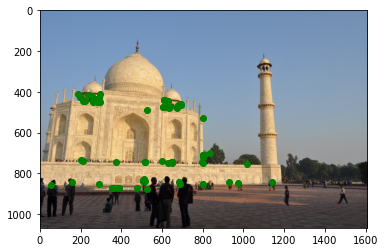

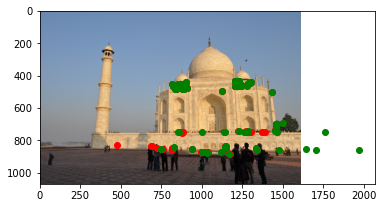

Average error is:  252.5091386665465


<Figure size 432x288 with 0 Axes>

In [6]:
im1 = cv2.cvtColor(cv2.imread("taj1.jpg"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("taj2.jpg"), cv2.COLOR_BGR2RGB)

points = np.load("taj_points.npz")
p1 =  points["p1"]
p2 =  points["p2"]
#im1 = points["im1"]
#im2 = points["im2"]


H2to1 = computeH(p2, p1)
p2_t = np.dot(H2to1, np.concatenate((p2.T, np.ones((1, p2.shape[0])))))
p2_t = p2_t / p2_t[2, :]
p2_t = p2_t.T[:,:2]

plt.imshow(im1)
plt.scatter(p1[:,0], p1[:,1], c="r")
plt.savefig("img1_p1.jpg")
plt.show()
plt.imshow(im2)
plt.scatter(p2[:,0], p2[:,1], c="g")
plt.savefig("img2_p2.jpg")
plt.show()
plt.imshow(im1)
plt.scatter(p1[:,0], p1[:,1], c="r")
plt.scatter(p2_t[:,0], p2_t[:,1], c="g")
plt.show(10, 10)
#plt.imshow()
plt.savefig("q2_4.jpg")
#plt.figure(figsize = (20,2))
np.savez("q2_4.npz", H2to1, p1, p2, p2_t)
#show_image(p2_t, title = "Warped im2", figsize = (15, 15))

#calculating average error
error = np.sqrt(np.mean(np.sum((p2_t - p1)**2, 1)))
print("Average error is: ", error)

### Q2.5 matrix M

In [7]:
def computeM(img1: np.array, img2: np.array, H:np.array) -> Tuple[np.array, Tuple[int, int]]:
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.array([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2).astype(np.float32)
    pts2 = np.array([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2).astype(np.float32)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.array(pts.min(axis=0).ravel() - 0.5).astype(np.int32)
    [xmax, ymax] = np.array(pts.max(axis=0).ravel() + 0.5).astype(np.int32)
    scale = 1280/(ymax-ymin)
    out_x = int(scale*(xmax-xmin))
    out_y = int(scale*(ymax-ymin))
    out_shape = (out_x, out_y)
    M = np.array([
        [scale,0,-scale*xmin],
        [0,scale,-scale*ymin],
        [0,0,1]])
    return M, out_shape

if __name__ == "__main__":
    points = np.load("taj_points.npz")
    p1     = points["p1"]
    p2     = points["p2"]
    im1    = points["im1"]
    im2    = points["im2"]
    H2to1 = computeH(p2, p1)
    M, out_size     = computeM(im1, im2, H2to1)
    print("Matrix is: \n", M)
    print("\n")
    print("out_size is: height == ", out_size[0], ", width == ", out_size[1])
    print("\n")
    print("out_size[1] == ", out_size[1])

Matrix is: 
 [[  0.75294118   0.          -0.        ]
 [  0.           0.75294118 349.36470588]
 [  0.           0.           1.        ]]


out_size is: height ==  2256 , width ==  1280


out_size[1] ==  1280


### Testing for Q2.5

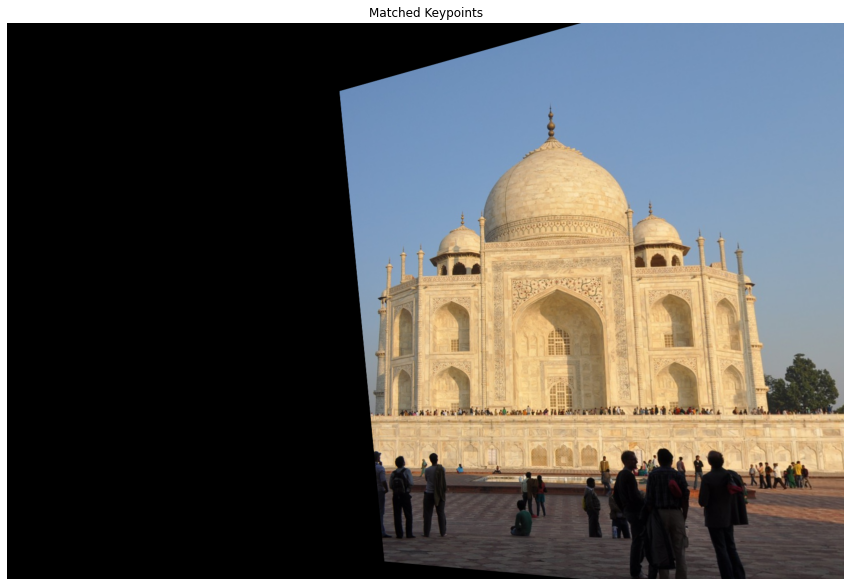

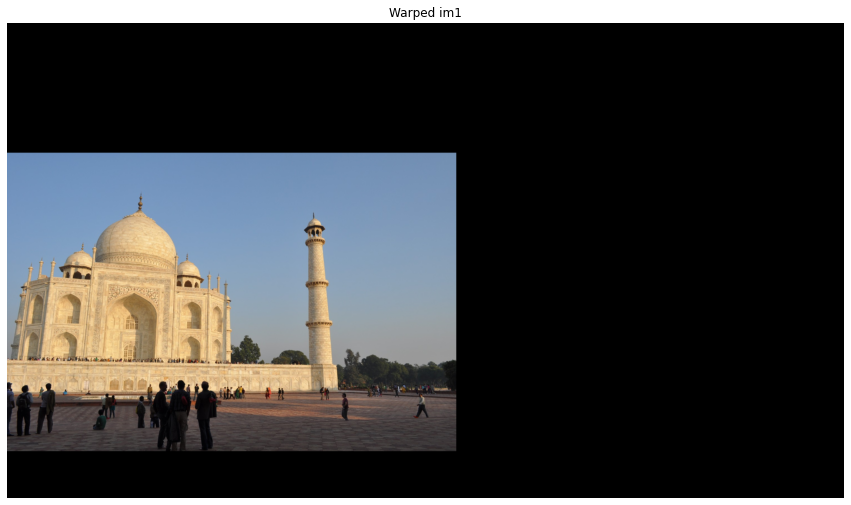

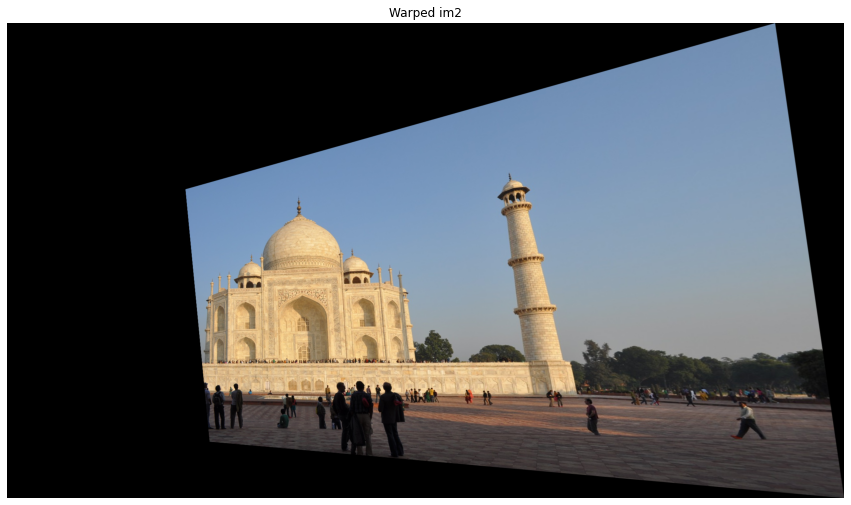

In [8]:
import warpH as wH

#H2to1 = computeH_norm(p1, p2)
warp_im = wH.warpH(im2, H2to1, (im1.shape[1], im1.shape[0]))
show_image(warp_im, title = "Matched Keypoints", figsize = (15, 15))

warp_im1 = wH.warpH(im2, M, out_size)
warp_im2 = wH.warpH(im2, M @ H2to1, out_size)

show_image(warp_im1, title = "Warped im1", figsize = (15, 15))
show_image(warp_im2, title = "Warped im2", figsize = (15, 15))

### Q2.6 Image blending

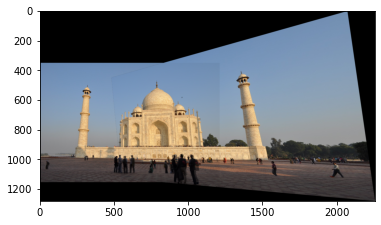

In [10]:
def warpTwoImages(img1, img2, H):
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    pts1 = np.array([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2).astype(np.float32)
    pts2 = np.array([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2).astype(np.float32)
    
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    
    [xmin, ymin] = np.array(pts.min(axis=0).ravel() - 0.5).astype(np.int32)
    [xmax, ymax] = np.array(pts.max(axis=0).ravel() + 0.5).astype(np.int32)
    scale = 1280/(ymax-ymin)
    out_x = int(scale*(xmax-xmin))
    out_y = int(scale*(ymax-ymin))
    out_shape = (out_x, out_y)
    M = np.array([
                [scale,0,-scale*xmin],
                [0,scale,-scale*ymin],
                [0,0,1]])
    
    result = cv2.warpPerspective(img2, M.dot(H), out_shape)
    tmp = np.zeros_like(result)
    tmp[int(-scale*ymin):int(-scale*ymin)+int(scale*h1),
        int(-scale*xmin):int(-scale*xmin)+int(scale*w1)] =\
        cv2.resize(img1, (int(scale*w1), int(scale*h1)))
    mask = np.logical_and(result > 0, tmp> 0)
    blend = 0.5*result[mask] + 0.5*tmp[mask]
    result[int(-scale*ymin):int(-scale*ymin)+int(scale*h1),
        int(-scale*xmin):int(-scale*xmin)+int(scale*w1)] =\
        cv2.resize(img1, (int(scale*w1), int(scale*h1)))
    
    result[mask] = blend
    
    return result
im1 = cv2.cvtColor(cv2.imread("taj1.jpg"), cv2.COLOR_BGR2RGB)
im2 = cv2.cvtColor(cv2.imread("taj2.jpg"), cv2.COLOR_BGR2RGB)

points = np.load("taj_points.npz")
p1 = points["p1"]
p2 = points["p2"]

H2to1 = computeH(p2, p1)
warp_im = warpTwoImages(im1, im2, H2to1)
plt.imshow(warp_im)
plt.savefig("q2_7.jpg")
plt.show()

### QX1 Estimating angle of rotation along  y axis

<ipython-input-14-38e09f2c3d39>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Ry = lambda x: np.array([


   direc: array([[1.]])
     fun: array(236.01300743)
 message: 'Optimization terminated successfully.'
    nfev: 29
     nit: 3
  status: 0
 success: True
       x: array([23.86725797])


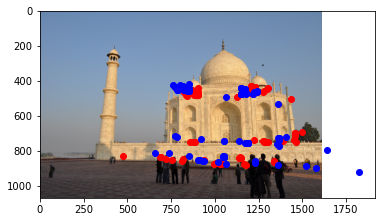

In [14]:
points = np.load("taj_points.npz")
p1 = points["p1"]
p2 = points["p2"]
alpha = 1274.4
beta = 1274.4
u0 = 814.1
v0 = 526.6

H2to1 = computeH(p2,p1)
K = np.array([
            [alpha, 0, u0],
            [0, beta, v0],
            [0, 0, 1]])

Ry = lambda x: np.array([
                        [np.cos(np.radians(x)), 0, np.sin(np.radians(x))],
                        [0, 1, 0],
                        [-np.sin(np.radians(x)), 0, np.cos(np.radians(x))]])

H = lambda x: K @ Ry(x) @ np.linalg.inv(K)

def objective(x):
    p2_t = np.dot(H(x), np.concatenate((p2.T, np.ones((1, p2.shape[0])))))
    p2_t = p2_t / p2_t[2, :]
    p2_t = p2_t.T[:,:2]
    return np.sqrt(np.mean(np.sum((p2_t - p1)**2, 1)))

res = minimize(objective, 0, tol=1e-3, method="Powell")
print(res)

p2_t = np.dot(H(res["x"]), np.concatenate((p2.T, np.ones((1, p2.shape[0])))))
p2_t = p2_t / p2_t[2, :]
p2_t = p2_t.T[:,:2]

plt.imshow(im1)

plt.scatter(p1[:,0], p1[:,1], c="r")
plt.scatter(p2_t[:,0], p2_t[:,1], c="b")
plt.show()

### QX2 Gaussian and laplacian blending

In [15]:
#Finding the Gaussian pyramid of the two images and the mask
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyr.append(np.float32(lower))
    return gaussian_pyr
 
# Calculating the Laplacian pyramid
def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr
 
# blending the two images wrt. the mask
def blend(laplacian_A,laplacian_B, mask_pyr):
    LS = []
    for la,lb,mask in zip(laplacian_A,laplacian_B,mask_pyr):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)
    return LS
 
# Reconstruct the original image
def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1
    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyr[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst

# calling the functions
if __name__ == '__main__':
    # Load the two images
    im1 = cv2.imread('alex.jpeg')
    im1 = cv2.resize(im1, (1200, 600))
    im2 = cv2.imread('oranges.jpeg')
    im2 = cv2.resize(im2, (1200, 600))
 
    # Create the mask
    mask = np.zeros((600,1200,3), dtype='float32')
    mask[250:500,640:1440,:] = (1,1,1)
    
    num_levels = 5
    
    # For image-1, calculate Gaussian and Laplacian
    gaussian_pyr_1 = gaussian_pyramid(im1, num_levels)
    laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)
    
    # For image-2, calculate Gaussian and Laplacian
    gaussian_pyr_2 = gaussian_pyramid(im2, num_levels)
    laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)
    
    # Calculate the Gaussian pyramid for the mask image and reverse it.
    mask_pyr_final = gaussian_pyramid(mask, num_levels)
    mask_pyr_final.reverse()
    
    # Blend the images
    add_laplace = blend(laplacian_pyr_1,laplacian_pyr_2,mask_pyr_final)
    
    # Reconstruct the images
    final  = reconstruct(add_laplace)
    
    # Save the final image to the disk
    cv2.imwrite('QX2.jpg',final[num_levels])

    #show_image(final[num_levels], title = "Warped im1", figsize = (15, 15))

### 3.1 Camera estimation 1

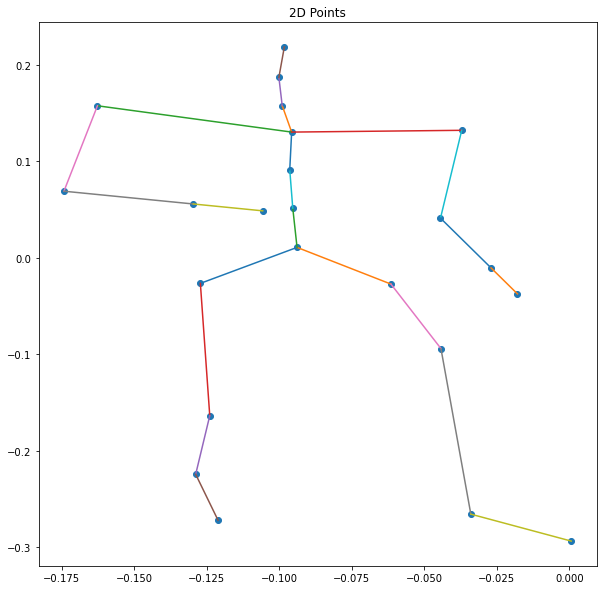

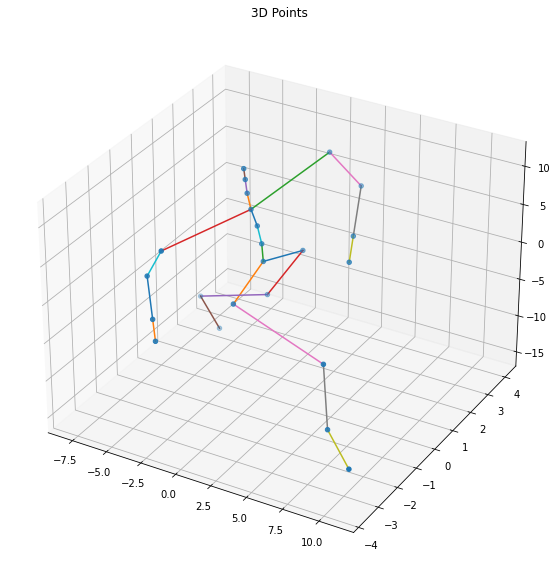

Rotation matrix is: 
 [[-2.00000000e-02  9.28783810e-18  1.77431514e-03]
 [-1.82330243e-18  2.00785506e-02 -2.92929932e-19]
 [-1.77431514e-03 -3.79947960e-17 -2.00000000e-02]]

 Translation vector is:  [-8.87157568e-02 -2.26303526e-17  1.00000000e+00]


In [16]:
#calling visualuse modules
import visualize2Dpoints as vs2D
import visualize3Dpoints as vs3D

def DLT(xyz, uv):
    '''
    Args:
    xyz: coordinates in the object 3D space.
    uv: coordinates in the image 2D space.
    '''
    n = xyz.shape[0]
    assert n >= 6, "[*] DLT requires at least 6 calibration points."
    assert uv.shape[0] == n
    assert xyz.shape[1] == 3
    Txyz, xyzn = normalize(xyz, 3)
    Tuv, uvn = normalize(uv, 2)
    A = []
    for i in range(n):
        x, y, z = xyzn[i, 0], xyzn[i, 1], xyzn[i, 2]
        u, v = uvn[i, 0], uvn[i, 1]
        A.append( [x, y, z, 1, 0, 0, 0, 0, -u * x, -u * y, -u * z, -u] )
        A.append( [0, 0, 0, 0, x, y, z, 1, -v * x, -v * y, -v * z, -v] )
    
    A = np.asarray(A)
    U, S, V = np.linalg.svd(A)
    L = V[-1, :] / V[-1, -1]
    H = L.reshape(3, 3 + 1)
    
    # Denormalization
    H = np.dot( np.dot( np.linalg.pinv(Tuv), H ), Txyz )
    H = H / H[-1, -1]
    return H

def estimateCamera(xy:np.array, XYZ:np.array) -> Tuple[np.array, np.array]:
    # assume K = np.eye(3)
    # estimate camera matrix (3x4)
    P = DLT(XYZ, xy)
    return P[:,0:3], P[:,3]

if __name__ == "__main__": 
    #calling visualise functins
    xy = io.loadmat("hw1_problem3.mat")["xy"]
    vs2D.visualize2Dpoints(xy)
    
    XYZ = io.loadmat("hw1_problem3.mat")["XYZ"]
    vs3D.visualize3Dpoints(XYZ)
    
    #changing xy to 2D numpy with rows and columns
    xy1 = []
    xy = np.array(xy)
    for i in range(0, len(xy)):
        xy1.append(xy[i][0])
        xy1.append(xy[i][1])
        
    xy1 = np.array(xy1)
    xy1 = xy1.reshape(-1, 2)
    
    #callinge estimate
    R_matrix, T_vector = estimateCamera(xy1, XYZ)
    print("Rotation matrix is: \n", R_matrix)
    print("\n Translation vector is: ", T_vector,)
    
    np.savez("visualize.npz", xy1 = xy1, XYZ = XYZ)

### 3.5 Camera estimation 2

In [17]:
def estimateCamera2(xy:np.array, XYZ:np.array) -> Tuple[np.array, np.array]:
    # estimate camera matrix (3x4)
    P = DLT(XYZ, xy)
    
    # Estimate C
    U, S, V = np.linalg.svd(P)
    C = V[-1,0:3] / V[-1, -1]
    
    # Estimating K and R by RQ decomposition.
    K, R = rq(P[0:3,0:3])

    D = np.diag(np.sign(np.diag(K)))
    K = K @ D
    R = D @ R
    t = -R @ C
    return R, t

if __name__ == "__main__": 
    visualize = np.load("visualize.npz")
    xy  = visualize["xy1"]
    XYZ = visualize["XYZ"]
    
    #callinge estimate
    R_matrix, T_vector = estimateCamera2(xy, XYZ)
    print("New rotation matrix is: \n", R_matrix)
    print("\n New translation vector is: ", T_vector,)

New rotation matrix is: 
 [[-9.96087835e-01 -8.91639825e-17  8.83686861e-02]
 [-2.56035904e-16  1.00000000e+00 -1.87702538e-15]
 [-8.83686861e-02 -1.89230770e-15 -9.96087835e-01]]

 New translation vector is:  [-4.41843431e+00  6.53875098e-14  4.98043918e+01]


### 3.6 Visualisation

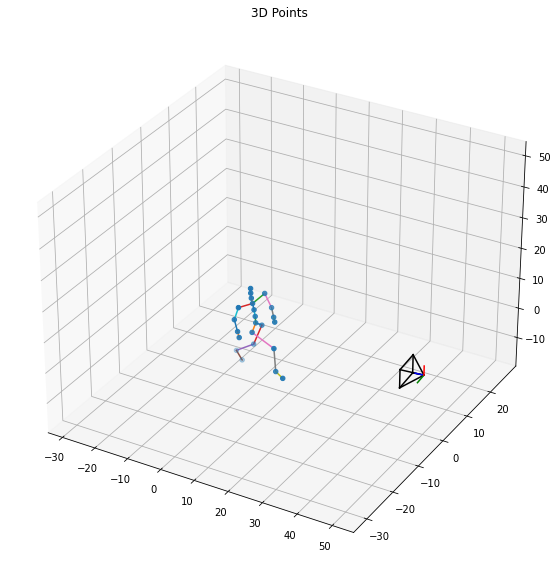

In [18]:
def visualize3Dpoints(XYZ, fig, ax):
    adj = io.loadmat("connectMat.mat")["connectMat"]
    pointX = [v[2] for v in XYZ]
    pointY = [v[0] for v in XYZ]
    pointZ = [v[1] for v in XYZ]
    plt.title("3D Points")
    ax.scatter(pointX, pointY, pointZ)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i][j] == 1:
                X = [pointX[i], pointX[j]]
                Y = [pointY[i], pointY[j]]
                Z = [pointZ[i], pointZ[j]]
                ax.plot(X, Y, Z)
def drawCam(R, t, fig, ax):
    scale = 6.0
    P = scale * np.array([[0.0, 0.0, 0.0],
                        [0.5, 0.5, 0.8],
                        [0.5, -0.5, 0.8],
                        [-0.5, 0.5, 0.8],
                        [-0.5, -0.5, 0.8]])
    t = t.reshape(-1, 1)
    P1_ = R.T @ (P.T - np.tile(t, (1, 5)))
    P1_ = P1_.T
    
    def P1(i, j):
        return P1_[i - 1, j - 1]

    def line(X, Y, Z, color = 'blue', **kwargs):
        ax.plot(Y, X, Z, color = color)
        
    line([P1(1,1), P1(2,1)], [P1(1,3), P1(2,3)], [P1(1,2), P1(2,2)], color = 'black')
    line([P1(1,1), P1(3,1)], [P1(1,3), P1(3,3)], [P1(1,2), P1(3,2)], color = 'black')
    line([P1(1,1), P1(4,1)], [P1(1,3), P1(4,3)], [P1(1,2), P1(4,2)], color = 'black')
    line([P1(1,1), P1(5,1)], [P1(1,3), P1(5,3)], [P1(1,2), P1(5,2)], color = 'black')
    
    line([P1(2,1), P1(3,1)], [P1(2,3), P1(3,3)], [P1(2,2), P1(3,2)], color = 'black')
    line([P1(3,1), P1(5,1)], [P1(3,3), P1(5,3)], [P1(3,2), P1(5,2)], color = 'black')
    line([P1(5,1), P1(4,1)], [P1(5,3), P1(4,3)], [P1(5,2), P1(4,2)], color = 'black')
    line([P1(4,1), P1(2,1)], [P1(4,3), P1(2,3)], [P1(4,2), P1(2,2)], color = 'black')
    
    cameraPlane = [[P1(2,1), P1(2,3), P1(2,2)], [P1(4,1), P1(4,3), P1(4,2)], [P1(3,1), P1(3,3), P1(3,2)], [P1(5,1), P1(5,3), P1(5,2)]]
    faces =[1, 0, 2, 3]
    cX = [cameraPlane[p][0] for p in faces]
    cY = [cameraPlane[p][1] for p in faces]
    cZ = [cameraPlane[p][2] for p in faces]
    
    verts = [list(zip(cY, cX, cZ))]
    patch = art3d.Poly3DCollection(verts, facecolors='green')
    
    # ax.add_collection3d(patch, zs='z')
    C1 = np.array([P1(2,1), P1(2,3), P1(2,2)])
    C2 = np.array([P1(3,1), P1(3,3), P1(3,2)])
    C3 = np.array([P1(4,1), P1(4,3), P1(4,2)])
    C4 = np.array([P1(5,1), P1(5,3), P1(5,2)])
    O = np.array([P1(1,1), P1(1,3), P1(1,2)])
    
    Cmid = 0.25 * (C1 + C2 + C3 + C4);
    
    Lz = np.stack([O, O + 0.5 * (Cmid - O)])
    Lx = np.stack([O, O + 0.5 * (C1 - C3)])
    Ly = np.stack([O, O + 0.5 * (C1 - C2)])
    line(Lz[:, 0], Lz[:, 1], Lz[:, 2], color = 'blue', linewidth = 2)
    line(Lx[:, 0], Lx[:, 1], Lx[:, 2], color = 'green', linewidth = 2)
    line(Ly[:, 0], Ly[:, 1], Ly[:, 2], color = 'red', linewidth = 2)

xyz = io.loadmat("hw1_problem3.mat")["XYZ"]
uv = io.loadmat("hw1_problem3.mat")["xy"][:,:2]

R, t = estimateCamera2(uv, xyz)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([xyz[:,0].max()-xyz[:,0].min(), xyz[:,1].max()-xyz[:,1].min(), t[2]-xyz[:,2].min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(xyz[:,0].max()+xyz[:,0].min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(xyz[:,1].max()+xyz[:,1].min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(t[2]+xyz[:,2].min())

for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

visualize3Dpoints(xyz, fig, ax)
drawCam(R, t, fig, ax)
plt.show()
